In [16]:
# !pip install ultralytics
# !pip install supervision
# !pip install opencv-python

# Imports

In [37]:
from IPython import display
display.clear_output()

import ultralytics
import supervision as sv

ultralytics.checks()
print("supervision", sv.__version__)

import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2   # We'll use OpenCV to overlay text on frames

from ultralytics import YOLO

Ultralytics 8.3.53  Python-3.12.4 torch-2.5.1 CPU (Intel Core(TM) i7-10510U 1.80GHz)
Setup complete  (8 CPUs, 15.8 GB RAM, 119.0/231.6 GB disk)
supervision 0.25.1


# Create a video from frames

In [ ]:
image_folder = "/frames"
output_video = 'mall_dataset_video.mp4'
fps = 2

# Get list of images sorted by name
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images.sort()

# Read the first image to get dimensions
first_image = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = first_image.shape

# Define the video codec and create VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # For mp4 format
video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Loop through the images and add them to the video
for image in images:
    img_path = os.path.join(image_folder, image)
    frame = cv2.imread(img_path)
    video.write(frame)

# Release the video writer
video.release()
cv2.destroyAllWindows()

print(f'Video created successfully: {output_video}')

# Load model

In [18]:
model = YOLO('yolov8s.pt')

file_path = "mall_dataset_video.mp4"

# Retrieve video info if needed for FPS or resolution
video_info = sv.VideoInfo.from_video_path(file_path)
print(f"Video FPS: {video_info.fps}, Total frames: {video_info.total_frames}")

Video FPS: 2, Total frames: 2000


# Quick test on a single frame


0: 480x640 20 persons, 4 handbags, 3 suitcases, 1 potted plant, 1 dining table, 297.1ms
Speed: 4.5ms preprocess, 297.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


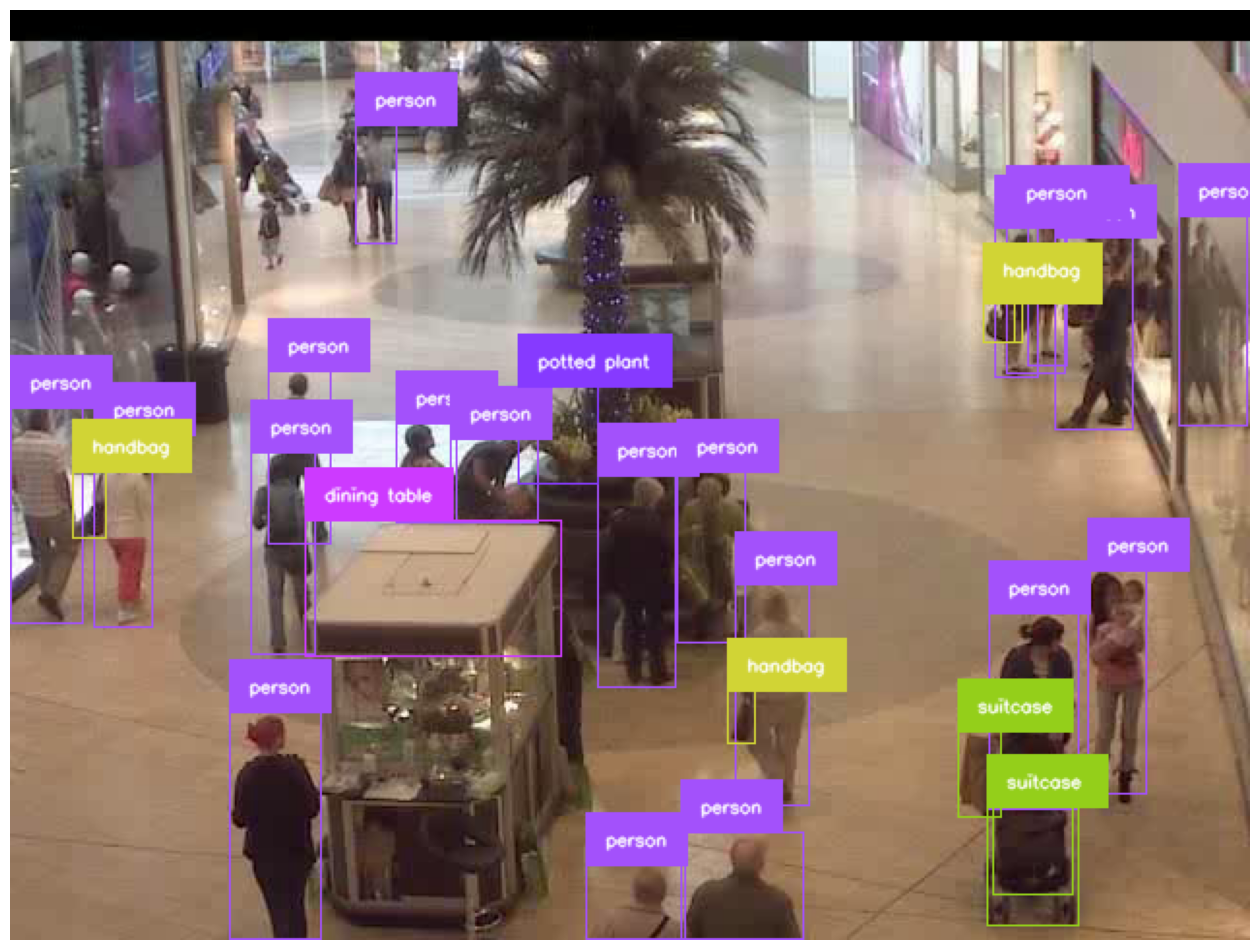

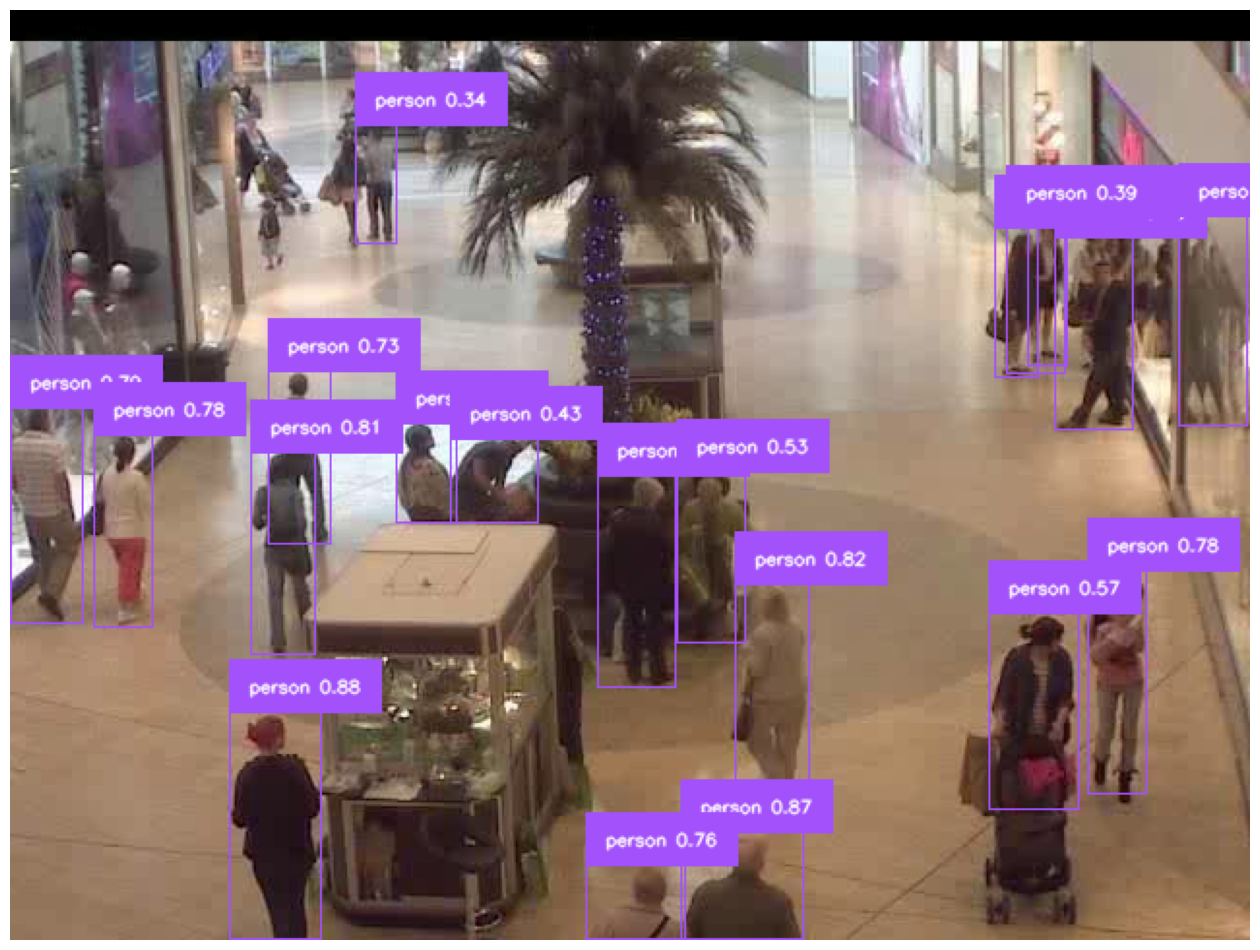

In [19]:
# Extract a single frame from the video
generator = sv.get_video_frames_generator(file_path)
iterator = iter(generator)
frame = next(iterator)

# Run detection
results = model(frame, imgsz=640)[0]
detections = sv.Detections.from_ultralytics(results)

# Annotators
box_annotator = sv.BoundingBoxAnnotator(thickness=1)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.3)

# Full detections (any class)
frame_annotated = box_annotator.annotate(scene=frame.copy(), detections=detections)
frame_annotated = label_annotator.annotate(scene=frame_annotated, detections=detections)

# Show
%matplotlib inline
sv.plot_image(frame_annotated, (16, 16))

# Now filter only people (class_id == 0)
detections_people = detections[detections.class_id == 0]
labels = [
    f"{model.names[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _, _ in detections_people
]

frame_filtered_annotated = box_annotator.annotate(scene=frame.copy(), detections=detections_people)
frame_filtered_annotated = label_annotator.annotate(scene=frame_filtered_annotated, 
                                                   detections=detections_people, 
                                                   labels=labels)
sv.plot_image(frame_filtered_annotated, (16, 16))

# Define polygon zones (front of shops)

In [20]:
colors = sv.ColorPalette.DEFAULT
polygons = [
    np.array([[100, 480], [160, 340], [340, 340], [290, 480]]),
    np.array([[150, 340], [200, 240], [420, 240], [360, 340]]),
    np.array([[180,  50], [170,  80], [270,  80], [240,  50]]),
    np.array([[120, 140], [ 90, 200], [150, 200], [150, 140]]),
    np.array([[500, 150], [560, 150], [590, 240], [520, 240]]),
    np.array([[400,  60], [450,  60], [530, 120], [460, 120]])
]

# Create zone objects
zones = [sv.PolygonZone(polygon=polygon) for polygon in polygons]

# Create annotators for zones

In [21]:
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=1,
        text_thickness=1,
        text_scale=1
    )
    for index, zone in enumerate(zones)
]

box_annotators = [
    sv.BoundingBoxAnnotator(
        color=colors.by_idx(index),
        thickness=1,
    )
    for index in range(len(polygons))
]

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings:

# Test on single frme to see zone annotation


0: 480x640 20 persons, 4 handbags, 3 suitcases, 1 potted plant, 1 dining table, 406.8ms
Speed: 3.8ms preprocess, 406.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


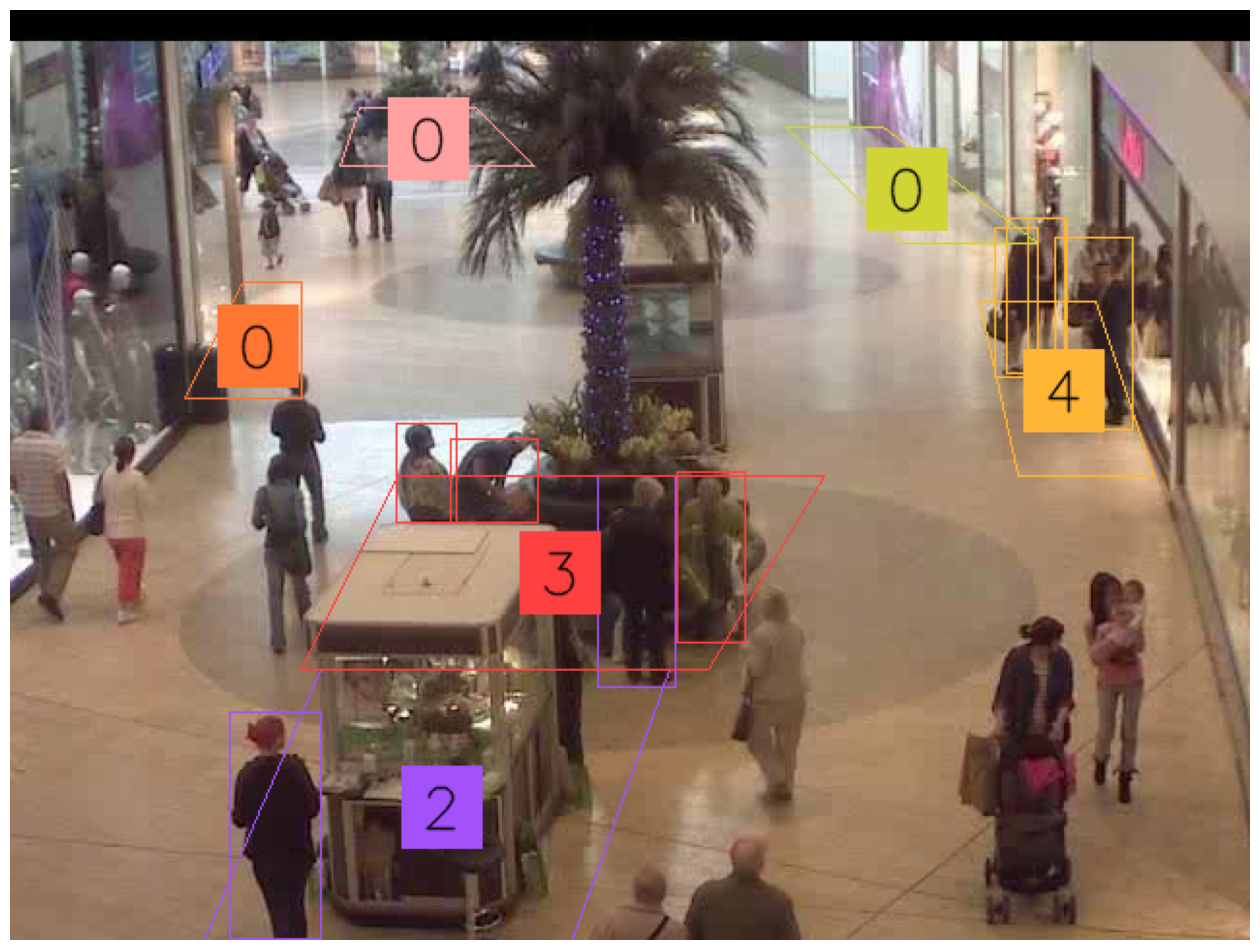

In [22]:
generator = sv.get_video_frames_generator(file_path)
iterator = iter(generator)
test_frame = next(iterator)

results_test = model(test_frame, imgsz=640)[0]
detections_test = sv.Detections.from_ultralytics(results_test)
detections_test = detections_test[detections_test.class_id == 0]

# Annotate each zone
for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections_test)
    detections_filtered = detections_test[mask]
    test_frame = box_annotator.annotate(scene=test_frame, detections=detections_filtered)
    test_frame = zone_annotator.annotate(scene=test_frame)

%matplotlib inline
sv.plot_image(test_frame, (16, 16))

In [23]:
for i, z in enumerate(zones, start=1):
    print(f"Zone {i} triggers: {z.trigger(detections_test)}")
    print(f"Zone {i} sum: {np.sum(z.trigger(detections_test))}")


Zone 1 triggers: [ True False False False False False False  True False False False False False False False False False False False False]
Zone 1 sum: 2
Zone 2 triggers: [False False False False False False False False False False  True False False False False  True  True False False False]
Zone 2 sum: 3
Zone 3 triggers: [False False False False False False False False False False False False False False False False False False False False]
Zone 3 sum: 0
Zone 4 triggers: [False False False False False False False False False False False False False False False False False False False False]
Zone 4 sum: 0
Zone 5 triggers: [False False False False False False False False False  True False False  True False  True False False  True False False]
Zone 5 sum: 4
Zone 6 triggers: [False False False False False False False False False False False False False False False False False False False False]
Zone 6 sum: 0


# GLOBALS for video processing

In [24]:
frame_num = 0

# We will store "cumulative person-seconds" for each zone 
# so we can display on the final video.
fps = video_info.fps
shop_attractiveness = [0.0]*len(zones)  # list of 6 floats, each for one zone

# Callback function for process_video

In [25]:
def process_frame(frame: np.ndarray, _) -> np.ndarray:
    """
    1) Detect people with YOLO.
    2) For each zone, compute how many people are inside.
    3) Convert that count to person-seconds (count * 1/fps), 
       and add to the cumulative attractiveness for that zone.
    4) Annotate bounding boxes/zones.
    5) Display the "shop attractiveness" text in bottom-right corner.
    6) Write counts to 'zones.csv'.
    """
    global frame_num, shop_attractiveness, fps
    frame_num += 1

    # Detect only people
    results = model(frame, imgsz=640)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.class_id == 0]

    zone_counts = []

    # Annotate each zone
    for i, (zone, zone_annotator, box_annotator) in enumerate(zip(zones, zone_annotators, box_annotators)):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]

        # How many people in this zone for the current frame
        count_i = np.sum(mask)
        zone_counts.append(count_i)

        # Update the cumulative person-seconds
        shop_attractiveness[i] += count_i * (1.0 / fps)

        # Draw bounding boxes & zone shape
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
        frame = zone_annotator.annotate(scene=frame)

    # === Overlay the shop attractiveness text in bottom-right ===
    # 1) We get the shape of the frame to compute coordinates
    h, w, _ = frame.shape

    # 2) Choose a smaller font scale
    font_scale = 0.4
    text_thickness = 1
    line_height = 15  # vertical spacing between lines
    x_offset = 10     # distance from right edge
    y_offset = 10     # distance from bottom edge

    # We'll start printing from bottom to top
    y = h - y_offset

    # Iterate over zones in reverse order so that zone1 is at the bottom if we want
    # Or if you want Zone1 at the top, remove the reversed() logic
    for i in reversed(range(len(shop_attractiveness))):
        zone_label = f"Zone {i+1}: {shop_attractiveness[i]:.2f} s"
        # Calculate text size for proper alignment
        text_size, _ = cv2.getTextSize(zone_label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_thickness)
        text_width, text_height = text_size

        # X coordinate so text is right-aligned
        x = w - x_offset - text_width
        # Put text so the bottom of the text is at 'y'
        cv2.putText(frame,
                    zone_label,
                    (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    (0, 255, 0),  # green color
                    text_thickness,
                    cv2.LINE_AA)

        # Move 'y' up for the next line
        y -= (text_height + line_height)

    # Write CSV row: frame index plus each zone count
    with open('zones.csv', 'a') as f:
        row_list = [str(frame_num)] + [str(c) for c in zone_counts]
        f.write(','.join(row_list) + '\n')

    return frame


# Initialize zones.csv and run process_video

In [26]:
with open('zones.csv', 'w') as f:
    f.write('frame,zone1,zone2,zone3,zone4,zone5,zone6\n')

sv.process_video(
    source_path=file_path, 
    target_path="final_output.mp4", 
    callback=process_frame
)

# Once the processing is finished, clear output to keep it clean
from IPython import display
display.clear_output()

# Anomaly detection

In [32]:
d = pd.read_csv('zones.csv')

anomalies = []
# Example logic: anomalies if zone >=4 for >=10 consecutive frames
for zone_idx in range(1, 7):
    consecutive_count = 0
    start_frame = None

    for idx, row in d.iterrows():
        if row[f'zone{zone_idx}'] >= 4:
            if consecutive_count == 0:
                start_frame = row['frame']
            consecutive_count += 1
        else:
            if consecutive_count >= 10:
                anomalies.append((zone_idx, start_frame, row['frame'] - 1))
            consecutive_count = 0

    # Check if the last sequence is an anomaly
    if consecutive_count >= 5:
        anomalies.append((zone_idx, start_frame, row['frame']))

# Print anomalies with timestamps

In [33]:
print("Detected Anomalies:")
for anomaly in anomalies:
    zone_id, start_f, end_f = anomaly
    start_time = start_f / video_info.fps
    end_time = end_f / video_info.fps
    start_minutes, start_seconds = divmod(start_time, 60)
    end_minutes, end_seconds = divmod(end_time, 60)
    print(f"Anomaly in zone {zone_id} from {int(start_minutes)}m {start_seconds:.2f}s "
          f"to {int(end_minutes)}m {end_seconds:.2f}s")

Detected Anomalies:
Anomaly in zone 1 from 7m 8.00s to 7m 13.50s
Anomaly in zone 1 from 7m 14.50s to 7m 20.00s
Anomaly in zone 1 from 7m 21.50s to 7m 26.00s
Anomaly in zone 1 from 7m 44.00s to 7m 51.50s
Anomaly in zone 1 from 13m 24.50s to 13m 31.50s
Anomaly in zone 1 from 13m 37.50s to 13m 50.00s
Anomaly in zone 2 from 4m 45.00s to 4m 50.00s


# Plot rolling averages

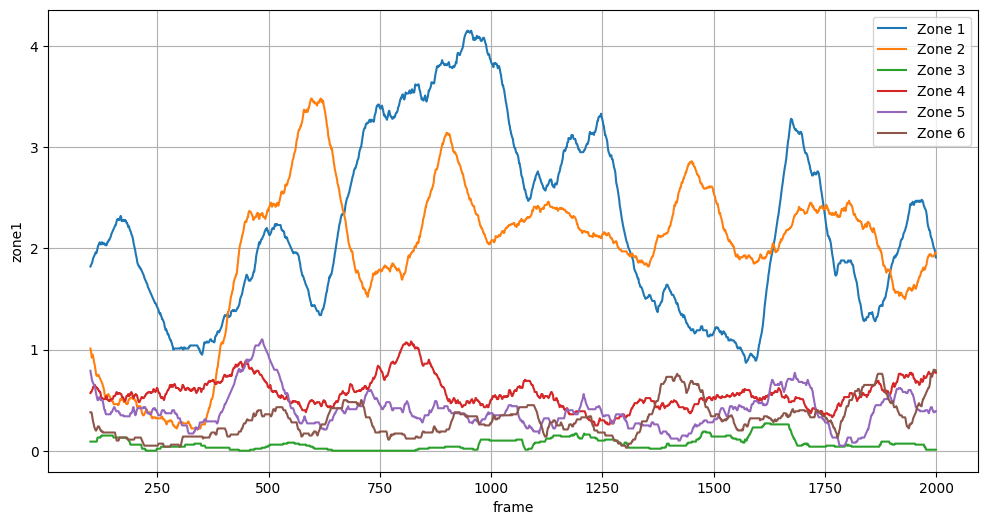

In [34]:
d = pd.read_csv('zones.csv')
d = d[d['frame'] < 2000]  # limit frames for plotting, if desired

w = 100  # rolling window
plt.figure(figsize=(12, 6))
plt.grid()

for z in range(1, 7):
    d[f'zone{z}'] = d[f'zone{z}'].rolling(window=w).mean()

sns.lineplot(data=d, x='frame', y='zone1', label='Zone 1')
sns.lineplot(data=d, x='frame', y='zone2', label='Zone 2')
sns.lineplot(data=d, x='frame', y='zone3', label='Zone 3')
sns.lineplot(data=d, x='frame', y='zone4', label='Zone 4')
sns.lineplot(data=d, x='frame', y='zone5', label='Zone 5')
sns.lineplot(data=d, x='frame', y='zone6', label='Zone 6')

plt.legend()
plt.show()


# Plot with anomalies highlighted

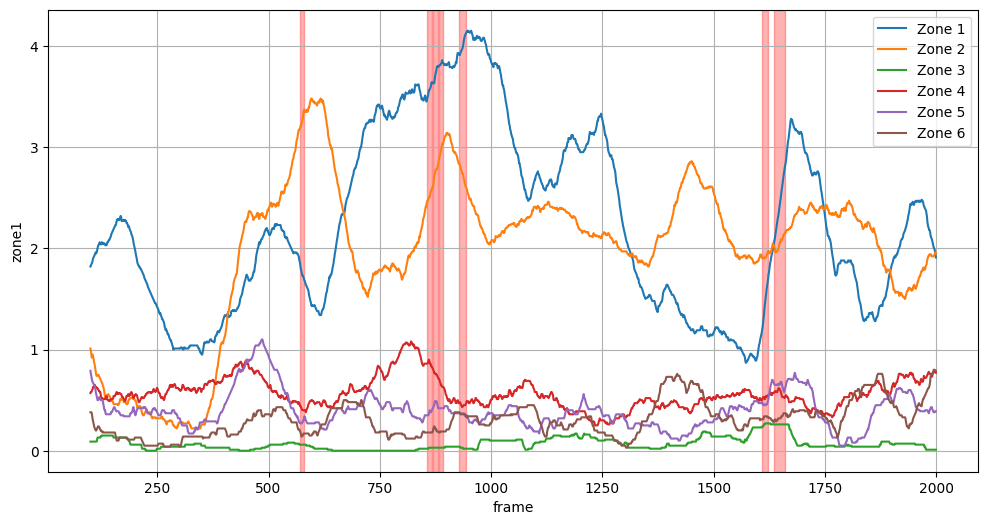

In [35]:
d = pd.read_csv('zones.csv')
d = d[d['frame'] < 2000]
w = 100

plt.figure(figsize=(12, 6))
plt.grid()

for z in range(1, 7):
    d[f'zone{z}'] = d[f'zone{z}'].rolling(window=w).mean()

sns.lineplot(data=d, x='frame', y='zone1', label='Zone 1')
sns.lineplot(data=d, x='frame', y='zone2', label='Zone 2')
sns.lineplot(data=d, x='frame', y='zone3', label='Zone 3')
sns.lineplot(data=d, x='frame', y='zone4', label='Zone 4')
sns.lineplot(data=d, x='frame', y='zone5', label='Zone 5')
sns.lineplot(data=d, x='frame', y='zone6', label='Zone 6')

# Highlight anomalies
for anomaly in anomalies:
    zone_id, start_f, end_f = anomaly
    plt.axvspan(start_f, end_f, color='red', alpha=0.3)

plt.legend()
plt.show()

# Shop attractiveness

In [36]:
print("\n=== FINAL SHOP ATTRACTIVENESS (person-seconds) ===")
for i, val in enumerate(shop_attractiveness, start=1):
    print(f"Zone {i}: {val:.2f} person-seconds")

# If you want to rank them:
zone_scores = [(i+1, val) for i, val in enumerate(shop_attractiveness)]
zone_scores_sorted = sorted(zone_scores, key=lambda x: x[1], reverse=True)

print("\n=== ZONES RANKED BY SHOP ATTRACTIVENESS ===")
for rank, (zid, score) in enumerate(zone_scores_sorted, start=1):
    print(f"Rank {rank}: Zone {zid} with {score:.2f} person-seconds")


=== FINAL SHOP ATTRACTIVENESS (person-seconds) ===
Zone 1: 2198.50 person-seconds
Zone 2: 1954.00 person-seconds
Zone 3: 66.50 person-seconds
Zone 4: 571.50 person-seconds
Zone 5: 414.50 person-seconds
Zone 6: 334.00 person-seconds

=== ZONES RANKED BY SHOP ATTRACTIVENESS ===
Rank 1: Zone 1 with 2198.50 person-seconds
Rank 2: Zone 2 with 1954.00 person-seconds
Rank 3: Zone 4 with 571.50 person-seconds
Rank 4: Zone 5 with 414.50 person-seconds
Rank 5: Zone 6 with 334.00 person-seconds
Rank 6: Zone 3 with 66.50 person-seconds
